# Semantic Segmentation of Ground and Pallets Using DeepLabV3

## Installs

In [2]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=6000b89529891fb1e6f428e09ce8ab4e3efaf27d009a2cd808841ea209edb7ba
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=00a5865ce9807c887b2f6a1021df6fe802fa12d5a246675a797a4934f40cc1fb
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

## Imports


In [3]:
import os
import random
import numpy as np
import copy
import time
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode, ColorJitter, RandomResizedCrop, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from torch.amp import autocast, GradScaler
import segmentation_models_pytorch as smp

# ============================
# 1. Set Random Seed for Reproducibility
# ============================

random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [4]:
# ============================
# 2. Define Paths
# ============================

HOME_DIR = "/content/drive/MyDrive/Pallets_detection"
SEG_DATASET_DIR = os.path.join(HOME_DIR, "Deeplabv3_ObjectSegmentation_Dataset")

train_images_dir = os.path.join(SEG_DATASET_DIR, "train", "images")
train_masks_dir = os.path.join(SEG_DATASET_DIR, "train", "masks")
val_images_dir = os.path.join(SEG_DATASET_DIR, "val", "images")
val_masks_dir = os.path.join(SEG_DATASET_DIR, "val", "masks")
test_images_dir = os.path.join(SEG_DATASET_DIR, "test", "images")
test_masks_dir = os.path.join(SEG_DATASET_DIR, "test", "masks")

### 3. Define map_mask Function
This function converts specific pixel values in masks to class labels, standardizing mask data to enable effective training.

### 4. Define Custom Dataset Class
Here, we create a custom dataset class to load images and corresponding masks, applying transformations and returning data in a compatible format for training.

In [5]:
# ============================
# 3. Define map_mask Function
# ============================

def map_mask(mask):
    """
    Maps specific pixel values in the mask to class indices.
    - 0 (Background) -> 0
    - 128 (Ground) -> 1
    - 255 (Pallet) -> 2
    """
    mask = np.array(mask)
    mask = np.where(mask == 128, 1, mask)  # Ground -> 1
    mask = np.where(mask == 255, 2, mask)  # Pallet -> 2
    mask = np.where((mask != 1) & (mask != 2), 0, mask)  # Background -> 0
    return mask

# ============================
# 4. Define Custom Dataset Class
# ============================

class PalletDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None):
        """
        Custom Dataset for Semantic Segmentation.

        Args:
            images_dir (str): Directory containing input images.
            masks_dir (str): Directory containing corresponding masks.
            image_transform (callable, optional): Transformations to apply to images.
            mask_transform (callable, optional): Transformations to apply to masks.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.masks_dir, mask_name)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask file {mask_path} does not exist for image {img_name}")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform and self.mask_transform:
            # Apply joint transformations using a seed to ensure consistency
            seed = np.random.randint(21)  # Make a seed with numpy generator

            random.seed(seed)
            torch.manual_seed(seed)
            image = self.image_transform(image)

            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.mask_transform(mask)
        else:
            if self.image_transform:
                image = self.image_transform(image)
            if self.mask_transform:
                mask = self.mask_transform(mask)

        mask = map_mask(mask)
        mask = torch.from_numpy(mask).long()
        return image, mask

### 5. Define Transformations
Transformations are applied to images and masks to augment the data. This includes resizing, flipping, and adjusting brightness, which helps prevent overfitting by diversifying the training data.

### 6. Initialize Datasets and DataLoaders
We initialize datasets and loaders for training, validation, and testing, enabling efficient and parallelized data loading during training.


In [6]:
# ============================
# 5. Define Transformations
# ============================

input_size = 512

# Image transformations for training with advanced augmentations
from torchvision.transforms import ColorJitter, RandomResizedCrop, RandomAffine

image_transform = Compose([
    RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(10),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = Compose([
    RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.9, 1.1), interpolation=InterpolationMode.NEAREST),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(10, interpolation=InterpolationMode.NEAREST),
])

# Image transformations for validation and testing (no augmentation)
val_test_image_transform = Compose([
    Resize((input_size, input_size), interpolation=InterpolationMode.BILINEAR),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Mask transformations for validation and testing (resize only)
val_test_mask_transform = Compose([
    Resize((input_size, input_size), interpolation=InterpolationMode.NEAREST)
])

# ============================
# 6. Initialize Datasets and DataLoaders
# ============================

batch_size = 8  # Increased batch size for better batch statistics
num_workers = 4

train_dataset = PalletDataset(
    images_dir=train_images_dir,
    masks_dir=train_masks_dir,
    image_transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = PalletDataset(
    images_dir=val_images_dir,
    masks_dir=val_masks_dir,
    image_transform=val_test_image_transform,
    mask_transform=val_test_mask_transform
)

test_dataset = PalletDataset(
    images_dir=test_images_dir,
    masks_dir=test_masks_dir,
    image_transform=val_test_image_transform,
    mask_transform=val_test_mask_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=num_workers
)

def plot_class_distribution(dataloader, num_classes=3):
    class_counts = np.zeros(num_classes)
    for _, masks in dataloader:
        masks = masks.numpy()
        for cls in range(num_classes):
            class_counts[cls] += np.sum(masks == cls)

    plt.bar(range(num_classes), class_counts, tick_label=['Background', 'Ground', 'Pallet'])
    plt.xlabel('Classes')
    plt.ylabel('Pixel Count')
    plt.title('Class Distribution')
    plt.show()

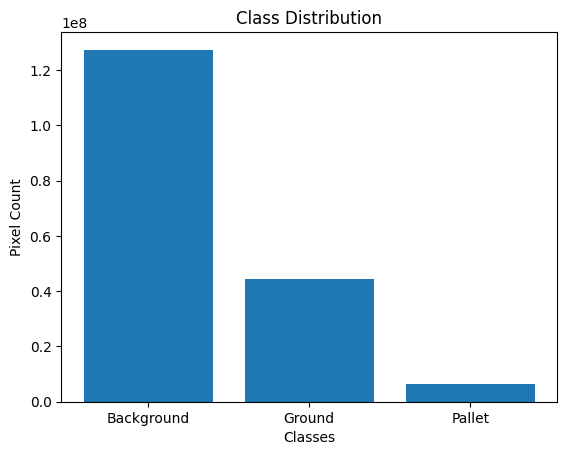

In [10]:
def plot_class_distribution(dataloader, num_classes=3):
    class_counts = np.zeros(num_classes)
    for _, masks in dataloader:
        masks = masks.numpy()
        for cls in range(num_classes):
            class_counts[cls] += np.sum(masks == cls)

    plt.bar(range(num_classes), class_counts, tick_label=['Background', 'Ground', 'Pallet'])
    plt.xlabel('Classes')
    plt.ylabel('Pixel Count')
    plt.title('Class Distribution')
    plt.show()

# Plot distribution for training set
plot_class_distribution(train_loader)


### 7. Define Model (DeepLabV3+)
Here, we define the **DeepLabV3+** model, a popular architecture for semantic segmentation. It’s chosen for its accuracy in segmenting complex objects, with **ResNet-101** as the backbone for a strong feature extraction base.

In [11]:
# ============================
# 7. Define Model (DeepLabV3+)
# ============================


# Create DeepLabV3+ model
def createDeepLabv3Plus(outputchannels=3, encoder_name='resnet101', encoder_weights='imagenet'):
    """
    Creates a DeepLabV3+ model using segmentation_models_pytorch.

    Args:
        outputchannels (int): Number of output classes.
        encoder_name (str): Name of the encoder backbone.
        encoder_weights (str): Pretrained weights for the encoder.

    Returns:
        model (torch.nn.Module): DeepLabV3+ model.
    """
    model = smp.DeepLabV3Plus(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=3,
        classes=outputchannels,
        activation=None
    )
    return model

# Instantiate the model
model = createDeepLabv3Plus(outputchannels=3, encoder_name='resnet101', encoder_weights='imagenet')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### 8. Define Loss, Optimizer, and Scheduler
In this section, we define:
- **Combined Loss (CrossEntropy + Dice Loss)**: CrossEntropy Loss handles classification, while Dice Loss addresses class imbalance and improves boundary accuracy, particularly useful in segmentation tasks with smaller classes.
- **Optimizer (AdamW)**: AdamW helps manage the model’s weight decay and is effective for segmentation due to its stability and efficiency.
- **Scheduler (CosineAnnealingWarmRestarts)**: The Cosine Annealing scheduler with warm restarts adjusts the learning rate dynamically, encouraging better convergence over multiple cycles.


In [12]:
# ============================
# 8. Define Loss, Optimizer, and Scheduler
# ============================

# Adjusted class weights using median frequency balancing
def calculate_class_weights(dataloader, num_classes=3):
    class_counts = np.zeros(num_classes)
    total_counts = 0
    for _, masks in dataloader:
        masks = masks.cpu().numpy()
        total_counts += masks.size
        for cls in range(num_classes):
            class_counts[cls] += np.sum(masks == cls)
    class_freqs = class_counts / total_counts
    median_freq = np.median(class_freqs)
    class_weights = median_freq / (class_freqs + 1e-6)  # Add small value to avoid division by zero
    return torch.tensor(class_weights, dtype=torch.float).to(device)

dataloaders = {'Train': train_loader, 'Val': val_loader}

class_weights = calculate_class_weights(dataloaders['Train'], num_classes=3)
print(f'Class weights: {class_weights}')
print(f'Class weights shape: {class_weights.shape}')  # Should output: torch.Size([3])

# Use a combination of CrossEntropyLoss and DiceLoss
class DiceLossCustom(nn.Module):
    def __init__(self, weight=None, ignore_index=None):
        super(DiceLossCustom, self).__init__()
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, num_classes=inputs.size(1)).permute(0, 3, 1, 2).float()
        dims = (0, 2, 3)
        intersection = torch.sum(inputs * targets_one_hot, dims)
        cardinality = torch.sum(inputs + targets_one_hot, dims)
        dice_score = 2. * intersection / (cardinality + 1e-6)
        return 1. - dice_score.mean()

# Combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, weight=None):
        super(CombinedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=weight)  # Removed ignore_index
        self.dice_loss = DiceLossCustom(weight=weight)    # Removed ignore_index

    def forward(self, inputs, targets):
        ce = self.ce_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        return ce + dice

criterion = CombinedLoss(weight=class_weights)

# Adjusted optimizer and learning rate
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Cosine Annealing Scheduler with Warm Restarts
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

Class weights: tensor([0.3502, 1.0000, 6.8862], device='cuda:0')
Class weights shape: torch.Size([3])


### 9. Define IoU Metric
We define the Intersection over Union (IoU) metric here, which measures segmentation accuracy by calculating overlap between predicted and true masks across classes.


In [13]:
# ============================
# 9. Define IoU Metric
# ============================

def calculate_iou_per_class(preds, masks, num_classes=3):
    """
    Calculates the Intersection over Union (IoU) for each class.

    Args:
        preds (torch.Tensor): Predicted segmentation maps of shape [batch_size, H, W].
        masks (torch.Tensor): Ground truth segmentation maps of shape [batch_size, H, W].
        num_classes (int): Number of classes.

    Returns:
        list: IoU for each class.
    """
    ious = []
    preds = preds.view(-1)
    masks = masks.view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = masks == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union > 0:
            ious.append(float(intersection) / float(union))
        else:
            ious.append(float('nan'))
    return ious  # List containing IoU for each class

metrics = {'iou_score': calculate_iou_per_class}

### 10. Define Training Function
The training function includes:
- **Automatic Mixed Precision (AMP)**: AMP optimizes memory and computational efficiency, which is beneficial for training complex models like DeepLabV3+ on GPUs.
- **Early Stopping**: Stops training when validation IoU no longer improves, preventing overfitting and unnecessary computation.
- **Mean IoU Tracking**: Mean IoU and per-class IoU tracking help us gauge model performance across all classes. The model with the best validation IoU is saved, ensuring we retain the most performant model.


In [4]:
# ============================
# 10. Define Training Function
# ============================

def train_model(model, criterion, dataloaders, optimizer, metrics, num_epochs=50, patience=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mean_iou = 0.0
    scaler = GradScaler()  # Updated GradScaler instantiation
    epochs_no_improve = 0
    since = time.time()

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()
                dataloader = dataloaders['Train']
            else:
                model.eval()
                dataloader = dataloaders['Val']

            running_loss = 0.0
            all_ious = []

            for batch_idx, (inputs, masks) in enumerate(dataloader):
                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    with autocast(device_type=device.type):  # Updated autocast usage
                        outputs = model(inputs)
                        loss = criterion(outputs, masks)
                    _, preds = torch.max(outputs, 1)
                    ious = calculate_iou_per_class(preds, masks, num_classes=3)
                    all_ious.append(ious)

                    if phase == 'Train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            all_ious = np.array(all_ious)
            epoch_ious = np.nanmean(all_ious, axis=0)
            mean_iou = np.nanmean(epoch_ious)

            print(f'{phase} Loss: {epoch_loss:.4f} Mean IoU: {mean_iou:.4f}')
            print(f'Per-Class IoU: Background={epoch_ious[0]:.4f}, Ground={epoch_ious[1]:.4f}, Pallet={epoch_ious[2]:.4f}')

            # Deep copy the model if we have a better mean IoU
            if phase == 'Val':
                scheduler.step()
                if mean_iou > best_mean_iou:
                    best_mean_iou = mean_iou
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(f'Best Val Mean IoU updated to {best_mean_iou:.4f}')
                else:
                    epochs_no_improve += 1
                    print(f'No improvement in Val Mean IoU for {epochs_no_improve} epochs.')

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {patience} epochs with no improvement.')
            break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Mean IoU: {best_mean_iou:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# ============================
# 11. Train the Model
# ============================

trained_model = train_model(model, criterion, dataloaders, optimizer, metrics, num_epochs=50)

# ============================
# 12. Save the Model
# ============================

model_dir = os.path.join(SEG_DATASET_DIR, "model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, "best_deeplabv3plus_model.pth")
torch.save(trained_model.state_dict(), model_path)
print(f'Model saved to {model_path}')




Class weights: tensor([0.3504, 1.0000, 6.8352], device='cuda:0')
Class weights shape: torch.Size([3])
Epoch 1/50
----------
Train Loss: 1.1166 Mean IoU: 0.5317
Per-Class IoU: Background=0.7466, Ground=0.7436, Pallet=0.1048
Val Loss: 0.7625 Mean IoU: 0.6302
Per-Class IoU: Background=0.8279, Ground=0.8944, Pallet=0.1684
Best Val Mean IoU updated to 0.6302

Epoch 2/50
----------
Train Loss: 0.8605 Mean IoU: 0.5830
Per-Class IoU: Background=0.7670, Ground=0.8385, Pallet=0.1435
Val Loss: 0.7209 Mean IoU: 0.5818
Per-Class IoU: Background=0.7139, Ground=0.9097, Pallet=0.1217
No improvement in Val Mean IoU for 1 epochs.

Epoch 3/50
----------
Train Loss: 0.7609 Mean IoU: 0.6129
Per-Class IoU: Background=0.7964, Ground=0.8728, Pallet=0.1694
Val Loss: 0.6864 Mean IoU: 0.6045
Per-Class IoU: Background=0.7540, Ground=0.9266, Pallet=0.1330
No improvement in Val Mean IoU for 2 epochs.

Epoch 4/50
----------
Train Loss: 0.6972 Mean IoU: 0.6356
Per-Class IoU: Background=0.8212, Ground=0.8890, Pallet=0

### 13. Post-Processing Function
This function applies morphological operations (opening and closing) to clean up segmentation masks, improving mask quality by smoothing boundaries.

### 14. Analyze Predictions
Finally, we visualize model predictions by decoding segmentation masks into color-coded images, comparing them to ground truth masks to assess performance.

In [14]:
# ============================
# 13. Post-Processing Function
# ============================

import cv2

def post_process(mask):
    """
    Apply morphological operations to clean up the mask.

    Args:
        mask (numpy.ndarray): Predicted mask.

    Returns:
        numpy.ndarray: Post-processed mask.
    """
    mask = mask.astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    # Opening (erosion followed by dilation)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # Closing (dilation followed by erosion)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

# ============================
# 14. Analyze Predictions
# ============================

def decode_segmap(image, num_classes):
    """
    Decodes a segmentation mask to an RGB image.

    Args:
        image (numpy.ndarray): Segmentation mask of shape [H, W].
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: RGB image of shape [H, W, 3].
    """
    label_colors = np.array([
        (0, 0, 0),          # Background - Black
        (128, 128, 128),    # Ground - Gray
        (255, 255, 255)     # Pallet - White
    ])
    r, g, b = [np.zeros_like(image).astype(np.uint8) for _ in range(3)]
    for l in range(num_classes):
        idx = image == l
        r[idx], g[idx], b[idx] = label_colors[l]
    return np.stack([r, g, b], axis=2)

# Load the best model weights
trained_model.load_state_dict(torch.load(model_path, map_location=device))
trained_model.eval()
print(f'Model loaded from {model_path}')

# Define directory to save plots
save_dir = "/content/segmentation_results"
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
    for idx, (input, mask) in enumerate(test_loader):
        input, mask = input.to(device), mask.to(device)
        output = trained_model(input)
        pred = torch.argmax(output, 1).cpu().squeeze().numpy()

        # Post-process the prediction
        pred = post_process(pred)

        input_np = input.cpu().squeeze().permute(1, 2, 0).numpy()
        # Denormalize
        input_np = (input_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        input_np = np.clip(input_np, 0, 1)

        mask_np, pred_np = mask.cpu().squeeze().numpy(), pred

        mask_rgb = decode_segmap(mask_np, num_classes=3)
        pred_rgb = decode_segmap(pred_np, num_classes=3)

        # Create the plot
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(input_np)
        axs[0].set_title('Input Image')
        axs[0].axis('off')

        axs[1].imshow(mask_rgb)
        axs[1].set_title('Ground Truth')
        axs[1].axis('off')

        axs[2].imshow(pred_rgb)
        axs[2].set_title('Predicted Segmentation')
        axs[2].axis('off')

        # Save the plot as an image file
        plot_path = os.path.join(save_dir, f"segmentation_result_{idx + 1}.png")
        plt.savefig(plot_path)
        print(f"Saved: {plot_path}")

        plt.close(fig)

        if idx >= 4:  # Only process first 5 images
            break

<ipython-input-14-7f951e28bb53>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded from /content/drive/MyDrive/Pallets_detection/Deeplabv3_ObjectSegmentation_Dataset/model/best_deeplabv3plus_model.pth
Saved: /content/segmentation_results/segmentation_result_1.png
Saved: /content/segmentation_results/segmentation_result_2.png
Saved: /content/segmentation_results/segmentation_result_3.png
Saved: /content/segmentation_results/segmentation_result_4.png
Saved: /content/segmentation_results/segmentation_result_5.png
